In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def preprocess_images(images, target_size=(300, 300)):
    preprocessed_images = []
    for img in images:
        if img.shape[:2] != target_size:
            img = cv.resize(img, target_size)
        if len(img.shape) == 2: 
            img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
        if img.shape[2] == 4: 
            img = cv.cvtColor(img, cv.COLOR_BGRA2BGR)
        if img.shape[2] != 3: 
            img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
        preprocessed_images.append(img)
    return np.array(preprocessed_images)

In [3]:
def display_sample(images, labels):
    unique_labels = list(set(labels))
    fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 5))
    
    for i, label in enumerate(unique_labels):
        idx = labels.index(label)
        img = images[idx]
        
        if img.dtype == np.float32 or img.dtype == np.float64:
            img = np.clip(img, 0, 1)
        else:
            img = np.clip(img, 0, 255).astype(np.uint8)
        
        axes[i].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        axes[i].set_title(label)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [4]:
def insertGambar(folder):
    data = []
    datalabel = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        for filename in tqdm(os.listdir(label_folder)):
            img_path = os.path.join(label_folder, filename)
            img = plt.imread(img_path)
            if img is not None:
                data.append(img)
                datalabel.append(label)
    return data, datalabel

In [6]:
def rotasi(image, derajat):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv.getRotationMatrix2D(center, derajat, 1.0)
    rotated = cv.warpAffine(image, M, (w, h))
    return rotated

In [7]:
def pencerminan(image, axis):
    return cv.flip(image, axis)

In [8]:
def augmentasi(data, labels, banyakData):
    augmented_data = []
    augmented_labels = []
    for i in tqdm(range(len(data))):
        augmented_data.append(data[i])
        augmented_labels.append(labels[i])
        for j in range(banyakData):
            if j % 2 == 0:
                rotated_90 = rotasi(data[i], 90)
                augmented_data.append(rotated_90)
                augmented_labels.append(labels[i])
            elif j % 2 == 1:
                rotated_minus_90 = rotasi(data[i], -90)
                augmented_data.append(rotated_minus_90)
                augmented_labels.append(labels[i])
            elif j % 4 == 2:
                flipped_axis_0 = pencerminan(data[i], 0)
                augmented_data.append(flipped_axis_0)
                augmented_labels.append(labels[i])
            elif j % 4 == 3:
                flipped_axis_1 = pencerminan(data[i], 1)
                augmented_data.append(flipped_axis_1)
                augmented_labels.append(labels[i])
    return augmented_data, augmented_labels

In [9]:
data, label = insertGambar("Sea Animal")
print("Data: ", len(data))
print("Label: ", len(label))

100%|██████████| 200/200 [00:00<00:00, 403.90it/s]

Data:  1150
Label:  1150


In [10]:
dataResize = preprocess_images(data, target_size=(300, 300))
augmented_data, augmented_labels = augmentasi(dataResize, label, banyakData=4)
print("Jumlah total dataset setelah augmentasi:", len(augmented_data))

100%|██████████| 1150/1150 [00:10<00:00, 113.04it/s]

Jumlah total dataset setelah augmentasi: 5750


In [11]:
def grayscale(data):
    dataGray = []
    for img in data:
        if len(img.shape) == 3:
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        else:
            gray = img
        dataGray.append(gray)
    return dataGray

def threshold(data):
    thresholdData = []
    for img in data:
        _, threshed_img = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
        threshed_img = threshed_img.astype(np.uint8)
        thresholdData.append(threshed_img)
    return thresholdData

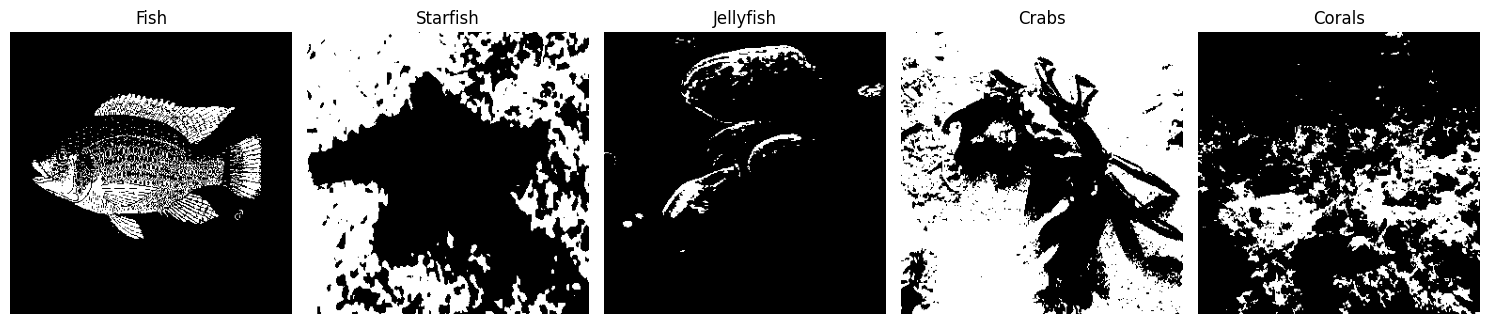

In [12]:
dataGray = grayscale(augmented_data)
dataThreshold = threshold(dataGray)
display_sample(dataThreshold, augmented_labels)

In [13]:
X_cnn = np.array(dataThreshold)
X_cnn = np.expand_dims(X_cnn, axis=-1)
X_cnn = X_cnn / 255.0

encoder = LabelEncoder()
y_cnn_encoded = encoder.fit_transform(augmented_labels)

X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X_cnn, y_cnn_encoded, test_size=0.2, random_state=42)

print("Training data shape:", X_cnn_train.shape)
print("Testing data shape:", X_cnn_test.shape)

Training data shape: (4600, 300, 300, 1)
Testing data shape: (1150, 300, 300, 1)


In [14]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

In [15]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)), 
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax') 
])

c:\Users\HAPPY COM\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [17]:
cnn_history = cnn_model.fit(
    X_cnn_train, y_cnn_train,
    validation_data=(X_cnn_test, y_cnn_test),
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.3407 - loss: 1.6565 - val_accuracy: 0.6052 - val_loss: 1.1097
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.6120 - loss: 1.0053 - val_accuracy: 0.7452 - val_loss: 0.7347
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.8139 - loss: 0.5145 - val_accuracy: 0.7922 - val_loss: 0.6343
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.8789 - loss: 0.3315 - val_accuracy: 0.8104 - val_loss: 0.6105
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9319 - loss: 0.2070 - val_accuracy: 0.8409 - val_loss: 0.5584
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9371 - loss: 0.1669 - val_accuracy: 0.8383 - val_loss: 0.6441
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9516 - loss: 0.1419 - val_accuracy: 0.8383 - val_loss: 0.7072
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9586 - loss: 0.1216 - val_accu

In [18]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_cnn_test, y_cnn_test)
y_cnn_pred = cnn_model.predict(X_cnn_test)
y_cnn_pred_classes = np.argmax(y_cnn_pred, axis=1)

print("Accuracy CNN:", cnn_accuracy)
print(classification_report(y_cnn_test, y_cnn_pred_classes))

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.8452 - loss: 0.5313
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step
Accuracy CNN: 0.8408695459365845
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       214
           1       0.89      0.86      0.88       247
           2       0.80      0.82      0.81       199
           3       0.83      0.89      0.86       298
           4       0.83      0.83      0.83       192

    accuracy                           0.84      1150
   macro avg       0.84      0.84      0.84      1150
weighted avg       0.84      0.84      0.84      1150



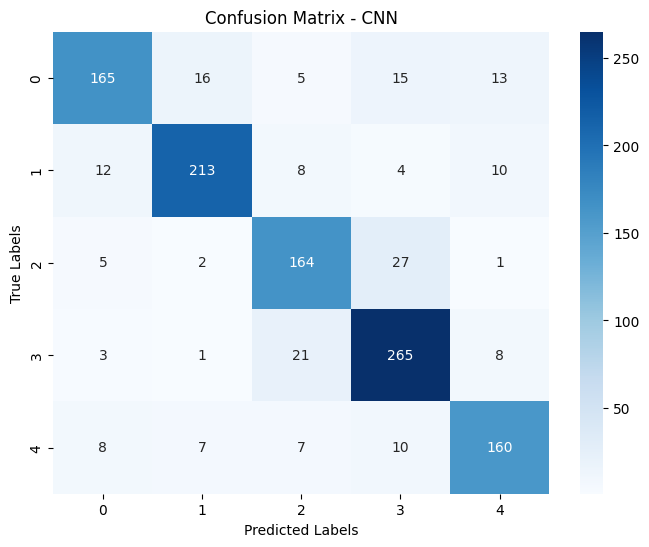

In [19]:
conf_matrix_cnn = confusion_matrix(y_cnn_test, y_cnn_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN')
plt.show()

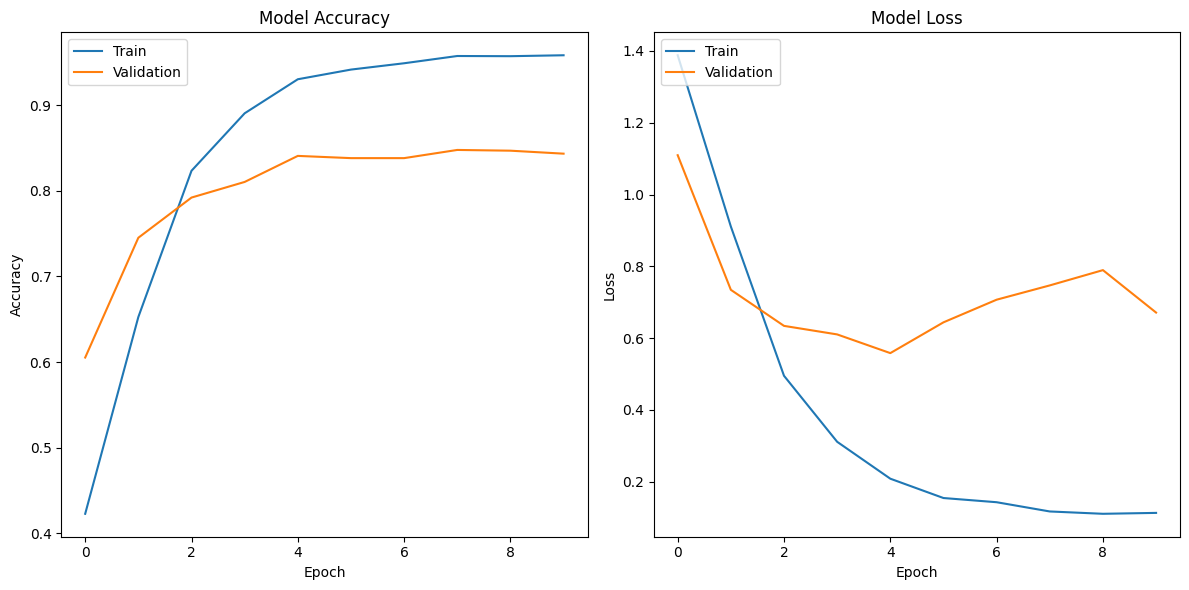

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()